In [66]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 50em; }</style>"))

# Импорты бибилиотек

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# Функция расстояния между координатами

In [68]:
import geopy.distance

def distance(lat1, lon1, lat2, lon2):
    return geopy.distance.distance((lat1, lon1), (lat2, lon2)).km

# Функция обрезания текста

In [69]:
def slide(txt, num):
    if (len(txt) <= num): return txt
    elif (len(txt) >= num - 3): return txt[:-(len(txt) - num + 3)] + '...'
    else: return '...'

# Данные Census

In [70]:
census = pd.read_csv('Census_Geo_Locality_Mt_Cities_Centers.csv', sep = ';')

census['okrug_mt'] = census['okrug_mt'].apply(lambda x: x.strip())
census['province_mt'] = census['province_mt'].apply(lambda x: x.strip())
census['locality_mt'] = census['locality_mt'].apply(lambda x: x.strip())
census['locality'] = census['locality'].apply(lambda x: x.strip())
census['city_nm'] = census['province_mt'].apply(lambda x: slide(x, 25)) + ' - ' + census['locality_mt'].apply(lambda x: slide(x, 25))
census['distance'] = census[['latitude', 'longitude', 'latitude_mt_avg', 'longitude_mt_avg']].apply(
    lambda row: distance(row['latitude'], row['longitude'], row['latitude_mt_avg'], row['longitude_mt_avg']),
    axis = 1
)
census['distance_text'] = census['distance'].map(lambda x: round(x, 2))
census['dist_all_rn'] = census.sort_values(by='distance', ascending=False)['distance'].rank(method='first', ascending=False).astype(np.int64)
census['dist_rn'] = census.sort_values(by='distance', ascending=False).groupby('partition_dt').cumcount() + 1

census.sort_values(by='dist_all_rn', ascending=True)[:5]

,partition_dt,okrug_mt,province_mt,locality_mt,count,latitude_mt_avg,longitude_mt_avg,locality,latitude,longitude,city_nm,distance,distance_text,dist_all_rn,dist_rn
1060,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,9465,59.784928,81.668948,Кемерово,55.354727,86.088374,Кемеровская область - Кемерово,559.512534,559.51,1,1
942,2020-05-01,Сибирский федеральный округ,Новосибирская область,Новосибирск,27796,57.971449,79.986596,Новосибирск,55.030199,82.920430,Новосибирская область - Новосибирск,373.959413,373.96,2,1
999,2020-05-01,Центральный федеральный округ,Ивановская область,Иваново,4633,54.307298,43.677003,Иваново,57.000348,40.973921,Ивановская область - Иваново,344.687317,344.69,3,2
963,2020-05-01,Сибирский федеральный округ,Алтайский край,Барнаул,11813,55.851087,81.261308,Барнаул,53.346785,83.776856,Алтайский край - Барнаул,322.665499,322.67,4,3
782,2020-07-01,Центральный федеральный округ,Московская область,Химки,11024,53.438578,39.892829,Химки,55.888740,37.430390,Московская область - Химки,315.608721,315.61,5,1


# Гистограмма отклонений расстояний центров городов Census

In [71]:
# Find Top 20 by distance for all data
census_all_sorted = census.sort_values(by='dist_all_rn', ascending=True).reset_index()
census_all_sorted_top = census_all_sorted[:20]

In [72]:
xs = (census_all_sorted_top['distance']).to_list()[::-1]
ys = (census_all_sorted_top['city_nm'] + ' - ' + census_all_sorted_top['partition_dt']).to_list()[::-1]

# Plot data as Bar Horizontal Histogram
plotBarAll(xs, ys)

# Гистограмма динамики отклонений расстояний городов Census

In [73]:
# Setup months
months = census['partition_dt'].drop_duplicates().sort_values().to_list()
# Setup data for every months
census_months_sorted_top = {}

# Adding data for each month in dict
for month in months:
    census_sorted = census[census['partition_dt'] == month].sort_values(by='dist_rn', ascending=True).reset_index()
    census_sorted_top = census_sorted[:20]
    xs = (census_sorted_top['distance']).to_list()[::-1]
    ys = (census_sorted_top['city_nm'] + ' - ' + census_sorted_top['partition_dt']).to_list()[::-1]
    ys2 = list(map(lambda x: '{:>60}'.format(x), ys))
    census_months_sorted_top.update({month: [xs, ys]})

# Plot data as Slider Bar Horizontal Histogram
plotBarHistory(months, census_months_sorted_top)

# Гистограмма отклонений расстояний одного города Census

In [74]:
# Setup locality to analyze
city_province = 'Кемеровская область'
city_locality = 'Кемерово'

# Find locality data
census_city_sorted = census[(census['province_mt'] == city_province) & (census['locality_mt'] == city_locality)]\
.sort_values(by='partition_dt', ascending=True).reset_index()
census_city_sorted_top = census_city_sorted[:20]

In [75]:
xs = census_city_sorted_top['locality_mt'] + ' - ' + census_city_sorted_top['partition_dt']
ys = census_city_sorted_top['distance']

# Plot data as Bar Vertical Histogram
plotBarLocality(xs, ys, barcolors = BAR_COLORS[13], linecolors = BAR_LINE_COLORS[14])

# Гео-визуализация на карте отклонений расстояний городов Census

In [76]:
census_one_month = census[census['partition_dt'] == '2020-04-01'].reset_index()

In [77]:
# Plot Geo Visualization
plotGeoPointsAndLines(census_one_month, city_color = 'blue', terminals_color = 'red')

# Гео-визуализация на карте границ терминалов городов Census

In [78]:
census_terminals = pd.read_csv('Census_Geo_Locality_Mt_Terminals.csv', sep = ';')

census_terminals['okrug_mt'] = census_terminals['okrug_mt'].apply(lambda x: x.strip())
census_terminals['province_mt'] = census_terminals['province_mt'].apply(lambda x: x.strip())
census_terminals['locality_mt'] = census_terminals['locality_mt'].apply(lambda x: x.strip())
census_terminals['locality'] = census_terminals['locality'].apply(lambda x: x.strip())
census_terminals['merchant_nm'] = census_terminals['merchant_nm'].apply(lambda x: x.strip())
census_terminals['terminal_id'] = census_terminals['terminal_id'].apply(lambda x: x.strip())
census_terminals['point_type'] = census_terminals['point_type'].apply(lambda x: x.strip())
census_terminals['city_nm'] = census_terminals['province_mt'].apply(lambda x: slide(x, 25)) + ' - ' + census_terminals['locality_mt'].apply(lambda x: slide(x, 25))
census_terminals['distance'] = census_terminals[['latitude', 'longitude', 'latitude_mt', 'longitude_mt']].apply(
    lambda row: distance(row['latitude'], row['longitude'], row['latitude_mt'], row['longitude_mt']),
    axis = 1
)
census_terminals['distance_text'] = census_terminals['distance'].map(lambda x: round(x, 2))
census_terminals['dist_all_rn'] = census_terminals.sort_values(by='distance', ascending=False)['distance'].rank(method='first', ascending=False).astype(np.int64)
census_terminals['dist_rn'] = census_terminals.sort_values(by='distance', ascending=False).groupby('partition_dt').cumcount() + 1

census_terminals[:5]

,partition_dt,okrug_mt,province_mt,locality_mt,merchant_city_nm,merchant_id,merchant_nm,terminal_id,geocode_quality_mt,region_denormalized_mt,...,avg_cheque,locality,latitude,longitude,distance,point_type,city_nm,distance_text,dist_all_rn,dist_rn
0,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 127,RZ331271,1,NULLVALUE,...,814.133970,Кемерово,55.354727,86.088374,3504.202546,large,Кемеровская область - Кемерово,3504.20,1,1
1,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,551125998504,RESURSAVTO,25998504,1,NULLVALUE,...,397.057778,Кемерово,55.354727,86.088374,3503.036387,large,Кемеровская область - Кемерово,3503.04,2,2
2,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,261000025237,SHKOLNOE PITANIE,22069911,1,NULLVALUE,...,1185.796296,Кемерово,55.354727,86.088374,3500.289713,large,Кемеровская область - Кемерово,3500.29,3,3
3,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 090,RZ330901,1,NULLVALUE,...,802.590990,Кемерово,55.354727,86.088374,3500.273017,large,Кемеровская область - Кемерово,3500.27,4,4
4,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 098,RZ330981,1,NULLVALUE,...,1024.545541,Кемерово,55.354727,86.088374,3500.212316,large,Кемеровская область - Кемерово,3500.21,5,5


In [79]:
# Setup month to analyze
terminals_month = '2020-04-01'

# Setup locality to analyze
terminals_city_province = 'Кемеровская область'
terminals_city_locality = 'Кемерово'

# Find locality data
census_city_city = census[(census['partition_dt'] == terminals_month) 
                                         & (census['province_mt'] == terminals_city_province)
                                         & (census['locality_mt'] == terminals_city_locality)].reset_index()

census_city_terminals = census_terminals[(census_terminals['partition_dt'] == terminals_month) 
                                         & (census_terminals['province_mt'] == terminals_city_province)
                                         & (census_terminals['locality_mt'] == terminals_city_locality)].reset_index()
census_city_terminals[:5]

,index,partition_dt,okrug_mt,province_mt,locality_mt,merchant_city_nm,merchant_id,merchant_nm,terminal_id,geocode_quality_mt,...,avg_cheque,locality,latitude,longitude,distance,point_type,city_nm,distance_text,dist_all_rn,dist_rn
0,0,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 127,RZ331271,1,...,814.133970,Кемерово,55.354727,86.088374,3504.202546,large,Кемеровская область - Кемерово,3504.20,1,1
1,1,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,551125998504,RESURSAVTO,25998504,1,...,397.057778,Кемерово,55.354727,86.088374,3503.036387,large,Кемеровская область - Кемерово,3503.04,2,2
2,2,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,261000025237,SHKOLNOE PITANIE,22069911,1,...,1185.796296,Кемерово,55.354727,86.088374,3500.289713,large,Кемеровская область - Кемерово,3500.29,3,3
3,3,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 090,RZ330901,1,...,802.590990,Кемерово,55.354727,86.088374,3500.273017,large,Кемеровская область - Кемерово,3500.27,4,4
4,4,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 098,RZ330981,1,...,1024.545541,Кемерово,55.354727,86.088374,3500.212316,large,Кемеровская область - Кемерово,3500.21,5,5


In [80]:
# Plot Geo Visualization
plotGeoLocalityEdges(census_city_city, census_city_terminals)

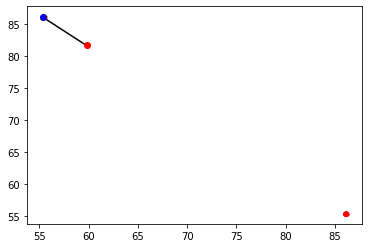

In [81]:
# Plot Plain Visualization
plotPlainLocalityEdges(census_city_city, census_city_terminals)

# Ошибочные координаты или адреса терминалов городов Census

In [82]:
census_show_fields = ['partition_dt', 'okrug_mt', 'province_mt', 'locality_mt',
                      'merchant_city_nm', 'merchant_id', 'merchant_nm', 'terminal_id',
                      'latitude_mt', 'longitude_mt', 'locality', 'latitude', 'longitude', 'distance', 'point_type']

census_city_terminals[census_show_fields][census_city_terminals['point_type'] == 'large']\
.sort_values(by='distance', ascending=False)[:20]

,partition_dt,okrug_mt,province_mt,locality_mt,merchant_city_nm,merchant_id,merchant_nm,terminal_id,latitude_mt,longitude_mt,locality,latitude,longitude,distance,point_type
0,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 127,RZ331271,86.17630,55.33274,Кемерово,55.354727,86.088374,3504.202546,large
1,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,551125998504,RESURSAVTO,25998504,86.16340,55.32566,Кемерово,55.354727,86.088374,3503.036387,large
2,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,261000025237,SHKOLNOE PITANIE,22069911,86.13515,55.35636,Кемерово,55.354727,86.088374,3500.289713,large
3,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 090,RZ330901,86.13379,55.33035,Кемерово,55.354727,86.088374,3500.273017,large
4,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 098,RZ330981,86.13428,55.35559,Кемерово,55.354727,86.088374,3500.212316,large
5,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 003,RZ330031,86.13786,55.43718,Кемерово,55.354727,86.088374,3500.202007,large
6,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,65240501,MANGAL,65240501,86.13090,55.32157,Кемерово,55.354727,86.088374,3500.042223,large
7,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,26182067,AZS N 33 VAHRUSHEVA,26182067,86.11580,55.41207,Кемерово,55.354727,86.088374,3498.261366,large
8,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,GPN11000,GAZPROMNEFT AZS 074,RZ33074A,86.11028,55.38787,Кемерово,55.354727,86.088374,3497.851769,large
9,2020-04-01,Сибирский федеральный округ,Кемеровская область,Кемерово,KEMEROVO,0000000Y0043449,OOO KUZBASSDORSTROY,Y0043449,86.10330,55.34891,Кемерово,55.354727,86.088374,3497.369871,large


# Вспомогательные переменные и функции

### Цветовые палитры для гистограмм

In [83]:
BAR_COLORS = [
    'rgba(255,   0,   0, 0.7)', 'rgba(255,  50,   0, 0.7)', # red
    'rgba(255, 105,   0, 0.7)', 'rgba(255, 155,   0, 0.7)', # orange
    'rgba(255, 225,   0, 0.7)', 'rgba(255, 255,  35, 0.7)', # yellow
    'rgba(200, 255,   0, 0.7)', 'rgba(100, 255,   0, 0.7)', # light green
    'rgba(  0, 150,  60, 0.7)', 'rgba( 20, 220,  80, 0.7)', # green
    'rgba(100, 255, 200, 0.7)', 'rgba(120, 220, 225, 0.7)', # light blue
    'rgba(115, 200, 255, 0.7)', 'rgba( 45, 120, 255, 0.7)', # blue
    'rgba(105,  25, 255, 0.7)', 'rgba(150,   0, 255, 0.7)', # purple
    'rgba(160, 100, 255, 0.7)', 'rgba(210, 120, 255, 0.7)', # light purple
    'rgba(210,  50, 120, 0.7)', 'rgba(255,  40,  80, 0.7)', # pink
]

In [84]:
BAR_LINE_COLORS = [
    'rgb(255,   0,   0)', 'rgb(255,  50,   0)', # red
    'rgb(255, 105,   0)', 'rgb(255, 155,   0)', # orange
    'rgb(255, 225,   0)', 'rgb(255, 255,  35)', # yellow
    'rgb(200, 255,   0)', 'rgb(100, 255,   0)', # light green
    'rgb(  0, 150,  60)', 'rgb( 20, 220,  80)', # green
    'rgb(100, 255, 200)', 'rgb(120, 220, 225)', # light blue
    'rgb(115, 200, 255)', 'rgb( 45, 120, 255)', # blue
    'rgb(105,  25, 255)', 'rgb(150,   0, 255)', # purple
    'rgb(160, 100, 255)', 'rgb(210, 120, 255)', # light purple
    'rgb(210,  50, 120)', 'rgb(255,  40,  80)', # pink
]

### Функции для получения выпуклой оболочки точек

In [85]:
# Returns the orientation of point p1 relative to point p2 using origin.
# Returns a negative value if p1 follows p2 in 'clockwise' direction.
def get_orientation(origin, p1, p2):
    return ((p2.x - origin.x) * (p1.y - origin.y)) - ((p1.x - origin.x) * (p2.y - origin.y))

In [86]:
from operator import itemgetter
from collections import namedtuple

Point = namedtuple("Point", "x y")

# Computes the points that make up the convex hull.
def jarvis_march(points):
    hull_points = []
    far_point = None
    # get leftmost point
    start = min(points, key=itemgetter(0))
    point = start
    hull_points.append(start)
    while far_point is not start:
        p1 = None
        for p in points:
            if p is point:
                continue
            else:
                p1 = p
                break
        far_point = p1
        for p2 in points:
            # do not compare to self or pivot point
            if p2 is point or p2 is p1:
                continue
            else:
                direction = get_orientation(point, far_point, p2)
                if direction > 0:
                    far_point = p2
        hull_points.append(far_point)
        point = far_point
    return hull_points

In [87]:
from matplotlib import pyplot as plot

# Displays points on the scatter plot for visualization.
def display_points(points, hull_points = [], title = 'Jarvis March: Convex Hull', pcolor = 'red', hcolor = 'blue'):
    # all points
    x = [p.x for p in points]
    y = [p.y for p in points]
    plot.plot(x, y, marker = '.', linestyle = 'None', color = pcolor)

    # hull points
    hx = [p.x for p in hull_points]
    hy = [p.y for p in hull_points]
    plot.plot(hx, hy, color = hcolor)

    plot.title(title)
    plot.show()

In [88]:
def dataFrameToPoints(dataFrame, colX, colY):
    return list(map(lambda x: Point(x[0], x[1]), dataFrame[[colX, colY]].values.tolist()))

In [89]:
def pointsToDataFrame(points):
    return pd.DataFrame({'x': list(map(lambda p: p.x, points)), 'y': list(map(lambda p: p.y, points))})

### Пример работы функции получения выпуклой оболочки

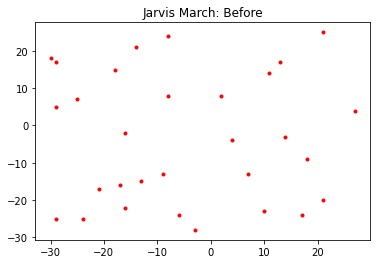

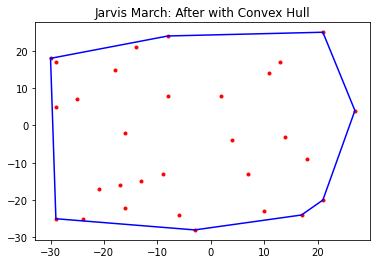

In [90]:
from collections import namedtuple
from random import randint, random, seed

# Setup seed to generate repeatable random numbers
seed(42)

# Setup number of points
n_points = 30
# Setup points
points = []

# Adding points
for _ in range(n_points):
    point = Point(randint(-n_points, n_points), randint(-n_points, n_points))
    points.append(point)

# Displaying before and after with convex hull
display_points(points, title = 'Jarvis March: Before')
display_points(points, jarvis_march(points), title = 'Jarvis March: After with Convex Hull')

### Функции для гео-визуализации на карте

In [91]:
def makeScatterMapLines(dataFrame, line_color = 'black'):
    scatterLines = []

    for i in range(dataFrame.shape[0]):
        scatterMapBox = go.Scattermapbox(
            mode = 'lines',
            lat = [dataFrame['latitude' ][i], dataFrame['latitude_mt_avg' ][i]],
            lon = [dataFrame['longitude'][i], dataFrame['longitude_mt_avg'][i]],
            text = dataFrame['city_nm'][i],
            marker = go.scattermapbox.Marker(
                size = 5,
                color = line_color,
                opacity = 0.5
            ),
            name = 'Линия {}'.format(dataFrame['city_nm'][i]),
            legendgroup = 'Линии',
            showlegend = False
        )
        scatterLines.append(scatterMapBox)
    return scatterLines

In [92]:
def makeScatterMapTerminals(dataFrame, terminals_color = 'red'):
    return go.Scattermapbox(
        mode = 'markers',
        lat = dataFrame['latitude_mt_avg' ],
        lon = dataFrame['longitude_mt_avg'],
        text = dataFrame['city_nm'],
        marker = go.scattermapbox.Marker(
            size = 10,
            color = terminals_color,
            opacity = 0.7
        ),
        name = 'Терминалы',
        showlegend = True
    )

In [93]:
def makeScatterMapCities(dataFrame, city_color = 'blue'):
    return go.Scattermapbox(
        mode = 'markers',
        lat = dataFrame['latitude'],
        lon = dataFrame['longitude'],
        text = dataFrame['city_nm'],
        marker = go.scattermapbox.Marker(
            size = 10,
            color = city_color,
            opacity = 0.7
        ),
        name = 'Города',
        showlegend = True
    )

In [94]:
def makeScatterMapPoints(dataFrame, name_prefix = '', points_color = 'black'):
    return go.Scattermapbox(
        mode = 'markers',
        lat = dataFrame['latitude_mt'],
        lon = dataFrame['longitude_mt'],
        text = dataFrame['merchant_nm'].apply(lambda x: slide(x, 25)) + ' - ' + dataFrame['terminal_id'].apply(lambda x: slide(x, 25)),
        marker = go.scattermapbox.Marker(
            size = 10,
            color = points_color,
            opacity = 0.7
        ),
        name = name_prefix + ' ' + 'Points',
        showlegend = False
    )

In [95]:
def makeScatterMapEdges(dataFrame, name_prefix = '', edges_color = 'black'):
    data = dataFrame[['merchant_nm', 'terminal_id']].values.tolist()
    all_points = list(map(lambda x: [x[0], x[1][0], x[1][1]],
                          zip(dataFrameToPoints(dataFrame, 'latitude_mt', 'longitude_mt'), data)))
    hull_points = list(map(lambda p: next(filter(lambda x: x[0] == p, all_points)),
                      jarvis_march(list(map(lambda x: x[0], all_points)))))
    return go.Scattermapbox(
        fill = 'toself',
        lat = list(map(lambda x: x[0].x, hull_points)),
        lon = list(map(lambda x: x[0].y, hull_points)),
        text = list(map(lambda x: slide(x[1], 25) + ' - ' + slide(x[2], 25), hull_points)),
        marker = go.scattermapbox.Marker(
            size = 10,
            color = edges_color,
            opacity = 0.7
        ),
        name = name_prefix + ' ' + 'Edges',
        showlegend = False
    )

In [96]:
def makeMapCenter(dataFrame):
    return go.layout.mapbox.Center(
        lat = (dataFrame['latitude' ].max() + dataFrame['latitude' ].min()) / 2.0,
        lon = (dataFrame['longitude'].max() + dataFrame['longitude'].min()) / 2.0
    )

### Функции визуализации

In [97]:
def plotBarAll(xs, ys, barcolors = BAR_COLORS[::-1], linecolors = BAR_LINE_COLORS[::-1]):
    # Create figure
    fig = go.Figure()

    # Add traces
    fig.add_trace(
        go.Bar(
            x = xs,
            y = ys,
            orientation = 'h',
            marker = dict(
                color = barcolors,
                line = dict(color = linecolors, width = 1)
            ),
            textposition = 'outside',
            texttemplate = '%{x:.2f}',
            outsidetextfont = dict(color = 'red', size = 12)
        )
    )

    # Set options
    fig.update_layout(
        showlegend = False,
        paper_bgcolor = 'rgb(248, 248, 255)',
        plot_bgcolor = 'rgb(248, 248, 255)',
        xaxis = dict(range=[0, round(max(xs) * 1.1)]),
        margin = dict(t = 20, b = 20)
    )

    # Plot figure
    fig.show()

In [98]:
def plotBarHistory(months, xyms, barcolors = BAR_COLORS[::-1], linecolors = BAR_LINE_COLORS[::-1]):
    # Create figure
    fig = go.Figure()

    for month in months:
        # Add traces
        fig.add_trace(
            go.Bar(
                visible = False,
                x = xyms[month][0],
                y = xyms[month][1],
                orientation = 'h',
                marker = dict(
                    color = barcolors,
                    line = dict(color = linecolors, width = 1)
                ),
                textposition = 'outside',
                texttemplate = '%{x:.2f}',
                outsidetextfont = dict(color = 'red', size = 12)
            )
        )

    # Make first trace visible
    fig.data[0].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method = 'update',
            args = [{'visible': [False] * len(fig.data)}]  # layout attribute
        )
        step['args'][0]['visible'][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active = 0,
        steps = steps,
        currentvalue = {'prefix': 'Отчетный месяц: '},
        bgcolor = 'rgba(0,0,255,0.5)',
        tickcolor = 'rgb(0,0,255)', ticklen = 10, tickwidth = 3,
        pad = {'t': 10},
        xanchor = 'right'
    )]

    # Set options
    fig.update_layout(
        sliders = sliders,
        paper_bgcolor = 'rgb(248, 248, 255)',
        plot_bgcolor = 'rgb(248, 248, 255)',
        xaxis = dict(range = [0, round(max(map(lambda kv: max(kv[1][0]), xyms.items())) * 1.1)]),
        legend = go.layout.Legend(
            orientation = "h",
            traceorder = 'reversed',
            x = 0.5,
            xanchor = 'center',
            yanchor = 'auto'
        ),
        margin = dict(l=5, r=5, t=30, b=30),
        width = 980,
        height = 630
    )

    # Plot figure
    fig.show()

In [99]:
def plotBarLocality(xs, ys, barcolors = BAR_COLORS[::-1], linecolors = BAR_LINE_COLORS[::-1]):
    # Create figure
    fig = go.Figure()

    # Add traces
    fig.add_trace(
        go.Bar(
            x = xs,
            y = ys,
            marker = dict(
                color = barcolors,
                line = dict(color = linecolors, width = 1)
            ),
            textposition = 'outside',
            texttemplate = '%{y:.2f}',
            outsidetextfont = dict(color = 'red', size = 12)
        )
    )

    # Set options
    fig.update_layout(
        showlegend = False,
        paper_bgcolor = 'rgb(248, 248, 255)',
        plot_bgcolor = 'rgb(248, 248, 255)',
        margin = dict(t=20, b=20),
        width = 980,
        height = 500
    )

    # Plot figure
    fig.show()

In [100]:
def plotGeoPointsAndLines(dataFrame, line_color = 'black', terminals_color = 'red', city_color = 'blue'):
    # Create figure
    fig = go.Figure()

    # Add lines traces
    for scatterMapBox in makeScatterMapLines(dataFrame, line_color):
        fig.add_trace(scatterMapBox)

    # Add terminals traces
    fig.add_trace(makeScatterMapTerminals(dataFrame, terminals_color))
    # Add cities traces
    fig.add_trace(makeScatterMapCities(dataFrame, city_color))
    # Find center of all points
    map_center = makeMapCenter(dataFrame)

    # Set options
    fig.update_layout(
        mapbox = {
            'style': 'open-street-map',
            'center': map_center,
            'zoom': 2.5
        },
        legend = go.layout.Legend(
            orientation = 'h',
            traceorder = 'reversed',
            x = 0.5,
            xanchor = 'center',
            yanchor = 'auto'
        ),
        margin = dict(l = 5, r = 5, t = 5, b = 5),
        width = 980,
        height = 340
    )

    # Plot figure
    fig.show()

In [101]:
def plotGeoLocalityEdges(dataFrame, edgesDataFrame, city_color = 'blue', terminals_color = 'red', line_color = 'black',
                         edge_center_color = 'green', edge_medium_color = 'orange', edge_large_color = 'red'):
    # Create figure
    fig = go.Figure()

    # Add Large Edges traces
    edgesLarge = edgesDataFrame[edgesDataFrame['point_type'] == 'large'].reset_index()
    fig.add_trace(makeScatterMapPoints(edgesLarge, name_prefix = 'Large', points_color = edge_large_color))
    fig.add_trace(makeScatterMapEdges(edgesLarge, name_prefix = 'Large', edges_color = edge_large_color))

    # Add Medium Edges traces
    edgesMedium = edgesDataFrame[edgesDataFrame['point_type'] == 'medium'].reset_index()
    fig.add_trace(makeScatterMapPoints(edgesMedium, name_prefix = 'Medium', points_color = edge_medium_color))
    fig.add_trace(makeScatterMapEdges(edgesMedium, name_prefix = 'Medium', edges_color = edge_medium_color))

    # Add Center Edges traces
    edgesCenter = edgesDataFrame[edgesDataFrame['point_type'] == 'center'].reset_index()
    fig.add_trace(makeScatterMapPoints(edgesCenter, name_prefix = 'Center', points_color = edge_center_color))
    fig.add_trace(makeScatterMapEdges(edgesCenter, name_prefix = 'Center', edges_color = edge_center_color))

    # Add lines traces
    for scatterMapBox in makeScatterMapLines(dataFrame, line_color):
        fig.add_trace(scatterMapBox)

    # Add terminals traces
    fig.add_trace(makeScatterMapTerminals(dataFrame, terminals_color))
    # Add cities traces
    fig.add_trace(makeScatterMapCities(dataFrame, city_color))
    # Find center of all points
    map_center = makeMapCenter(edgesDataFrame)

    # Set options
    fig.update_layout(
        mapbox = {
            'style': 'open-street-map',
            'center': map_center,
            'zoom': 2.5
        },
        legend = go.layout.Legend(
            orientation = 'h',
            traceorder = 'reversed',
            x = 0.5,
            xanchor = 'center',
            yanchor = 'auto'
        ),
        margin = dict(l = 5, r = 5, t = 5, b = 5),
        width = 980,
        height = 340
    )

    # Plot figure
    fig.show()

In [102]:
from matplotlib import pyplot as plot

def plotPlainLocalityEdges(dataFrame, edgesDataFrame, city_color = 'blue', terminals_color = 'red', line_color = 'black',
                         edge_center_color = 'green', edge_medium_color = 'orange', edge_large_color = 'red'):
    # Add Large Edges traces
    edgesLarge = edgesDataFrame[edgesDataFrame['point_type'] == 'large'].reset_index()
    plot.plot(
        edgesLarge['latitude_mt'].values.tolist(),
        edgesLarge['longitude_mt'].values.tolist(),
        marker = '.', linestyle = 'None', color = edge_large_color)
    hull_edgesLarge = pointsToDataFrame(jarvis_march(dataFrameToPoints(edgesLarge, 'latitude_mt', 'longitude_mt')))
    plot.plot(
        hull_edgesLarge['x'].values.tolist(),
        hull_edgesLarge['y'].values.tolist(),
        marker = '.', color = edge_large_color)

    # Add Medium Edges traces
    edgesMedium = edgesDataFrame[edgesDataFrame['point_type'] == 'medium'].reset_index()
    plot.plot(
        edgesMedium['latitude_mt'].values.tolist(),
        edgesMedium['longitude_mt'].values.tolist(),
        marker = '.', linestyle = 'None', color = edge_medium_color)
    hull_edgesMedium = pointsToDataFrame(jarvis_march(dataFrameToPoints(edgesMedium, 'latitude_mt', 'longitude_mt')))
    plot.plot(
        hull_edgesMedium['x'].values.tolist(),
        hull_edgesMedium['y'].values.tolist(),
        marker = '.', color = edge_medium_color)

    # Add Center Edges traces
    edgesCenter = edgesDataFrame[edgesDataFrame['point_type'] == 'center'].reset_index()
    plot.plot(
        edgesCenter['latitude_mt'].values.tolist(),
        edgesCenter['longitude_mt'].values.tolist(),
        marker = '.', linestyle = 'None', color = edge_center_color)
    hull_edgesCenter = pointsToDataFrame(jarvis_march(dataFrameToPoints(edgesCenter, 'latitude_mt', 'longitude_mt')))
    plot.plot(
        hull_edgesCenter['x'].values.tolist(),
        hull_edgesCenter['y'].values.tolist(),
        marker = '.', color = edge_center_color)

    # Add lines traces
    for i in range(dataFrame.shape[0]):
        plot.plot(
            [dataFrame['latitude_mt_avg'][i], dataFrame['latitude'][i]],
            [dataFrame['longitude_mt_avg'][i], dataFrame['longitude'][i]],
            marker = '.', color = line_color)

    # Add terminals traces
    plot.plot(
        dataFrame['latitude_mt_avg'].values.tolist(),
        dataFrame['longitude_mt_avg'].values.tolist(),
        marker = '.', linestyle = 'None', markersize = 12, color = terminals_color)

    # Add cities traces
    plot.plot(
        dataFrame['latitude'].values.tolist(),
        dataFrame['longitude'].values.tolist(),
        marker = '.', linestyle = 'None', markersize = 12, color = city_color)

    plot.show()

In [103]:
exmapleDf = pd.DataFrame(data = {
    'city_nm': ['Moscow'],
    'latitude': [55.7],
    'longitude': [37.5],
    'latitude_mt_avg': [57.2],
    'longitude_mt_avg': [38.0]
})

exmapleDf

,city_nm,latitude,longitude,latitude_mt_avg,longitude_mt_avg
0,Moscow,55.7,37.5,57.2,38.0


In [104]:
exmapleEdgesDf = pd.DataFrame(data = {
    'city_nm': ['Moscow', 'Moscow', 'Moscow', 'Moscow', 'Moscow', 'Moscow', 'Moscow', 'Moscow', 'Moscow', 'Moscow', 'Moscow', 'Moscow'],
    'point_type': ['center', 'center', 'center', 'center', 'medium', 'medium', 'medium', 'medium', 'large', 'large', 'large', 'large'],
    'merchant_nm': ['merch_1', 'merch_2', 'merch_3', 'merch_4', 'merch_5', 'merch_6', 'merch_7', 'merch_8', 'merch_9', 'merch_10', 'merch_11', 'merch_12'],
    'terminal_id': ['term_1', 'term_2', 'term_3', 'term_4', 'term_5', 'term_6', 'term_7', 'term_8', 'term_9', 'term_10', 'term_11', 'term_12'],
    'latitude_mt':  [55.0, 56.0, 55.0, 56.0,  53.0, 58.0, 53.0, 58.0,  52.0, 59.0, 52.0, 59.0],
    'longitude_mt': [37.0, 37.0, 38.0, 38.0,  35.0, 35.0, 40.0, 40.0,  33.0, 33.0, 42.0, 42.0],
    'latitude':     [55.7, 55.7, 55.7, 55.7,  55.7, 55.7, 55.7, 55.7,  55.7, 55.7, 55.7, 55.7],
    'longitude':    [37.5, 37.5, 37.5, 37.5,  37.5, 37.5, 37.5, 37.5,  37.5, 37.5, 37.5, 37.5]
})

exmapleEdgesDf[:5]

,city_nm,point_type,merchant_nm,terminal_id,latitude_mt,longitude_mt,latitude,longitude
0,Moscow,center,merch_1,term_1,55.0,37.0,55.7,37.5
1,Moscow,center,merch_2,term_2,56.0,37.0,55.7,37.5
2,Moscow,center,merch_3,term_3,55.0,38.0,55.7,37.5
3,Moscow,center,merch_4,term_4,56.0,38.0,55.7,37.5
4,Moscow,medium,merch_5,term_5,53.0,35.0,55.7,37.5


In [105]:
plotGeoLocalityEdges(exmapleDf, exmapleEdgesDf)

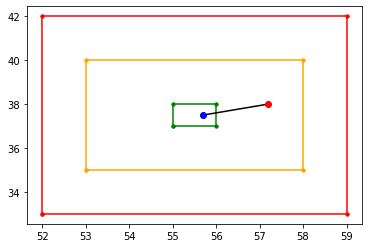

In [106]:
plotPlainLocalityEdges(exmapleDf, exmapleEdgesDf)